In [18]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import numpy as np
import pickle



In [19]:
region = 'SAtoES'
start_year = 1985.

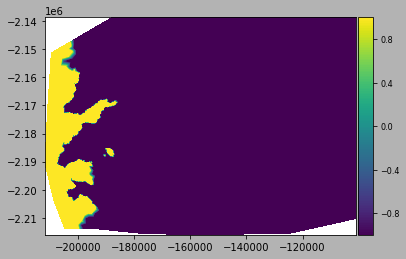

In [26]:
md = loadmodel('./Models/SAtoES_inversion.nc')
plotmodel(md, 'data', md.mask.ice_levelset)

In [21]:
## Relaxation
#Put results of inversion back into the model for forward runs
md.friction.coefficient=md.results.StressbalanceSolution.FrictionCoefficient
relaxation_years = 1 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' +region+ '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1])

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [27]:
# We set the transient parameters
md.transient.ismovingfront=1
md.transient.isthermal=0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the calving model (no moving front ... spclevelset is actually ignored)
md.levelset.spclevelset = np.nan * np.ones([md.mesh.numberofvertices,1])
md.calving.calvingrate = np.ones([md.mesh.numberofvertices,1])
md.frontalforcings.meltingrate = np.ones([md.mesh.numberofvertices,1])
#md.calving.meltingrate = np.ones([md.mesh.numberofvertices,1])

# Set bed = base for grounded ice
#md.geometry.base = md.geometry.bed
#md.geometry.thickness = md.geometry.surface - md.geometry.base

# Set the requested outputs
md.stressbalance.requested_outputs=['default']
md.transient.requested_outputs=['default','IceVolumeAboveFloatation']

# Go solve
md.verbose.solution=1
md.cluster = generic()
md.settings.waitonlock = np.inf
md = solve(md,'transient')

checking model consistency
marshalling file SAtoES.bin
uploading input file and queueing script
launching solution sequence on remote cluster
cd /efs/issm/issm/trunk-jpl-denis/execution && rm -rf ./SAtoES-07-19-2022-12-14-49-315 && mkdir SAtoES-07-19-2022-12-14-49-315 && cd SAtoES-07-19-2022-12-14-49-315 && mv ../SAtoES-07-19-2022-12-14-49-315.tar.gz ./&& tar -zxf SAtoES-07-19-2022-12-14-49-315.tar.gz  && chmod 755 SAtoES.queue && ./SAtoES.queue

Ice Sheet System Model (ISSM) version  4.19
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

call computational core:
iteration 1/50  time [yr]: 1985 (time step: 0.02)
   computing smb 
   computing new velocity
   computing calving and undercutting
   computing new ice front position
   computing slope of levelset function...
   extrapolation of Vx:
   extrapolation of Vy:
   extrapolation of Thickness:
   call computational core:
   looking for icebergs to kill
   computing basal mass balance
   computing mass transport
   cal

In [39]:
from export_netCDF import export_netCDF

md.inversion.cost_functions = md.inversion.cost_functions.astype(np.float64)
for i in range(len(md.results.TransientSolution)):
    md.results.TransientSolution[i].step = np.float64(md.results.TransientSolution[i].step)
    
export_netCDF(md, "./Models/SAtoES_relaxation.nc")

File ./Models/SAtoES_relaxation.nc allready exist


Give a new name or "delete" to replace:  delete


field md.solidearth.external is None
qmu is skipped until it is more stable


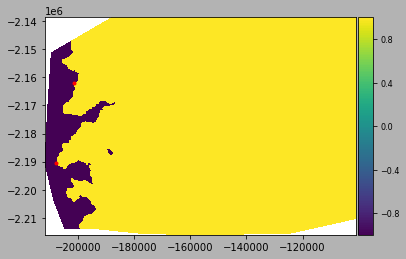

In [74]:
time = [md.results.TransientSolution[i].time for i in range(len(md.results.TransientSolution))]
VAF = [md.results.TransientSolution[i].IceVolumeAboveFloatation for i in range(len(md.results.TransientSolution))]

idx = np.logical_and(np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel() >= 0, \
                     np.array(md.mask.ice_levelset) < 0)
pos = np.where(idx)[0]

#fig = plt.figure(figsize=(10,10))
#plotmodel(md, 'data', np.array(md.mask.ice_levelset), \
#              'data', np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1., +1.])
plotmodel(md, 'data', np.array(md.mask.ice_levelset) - np.array(md.results.TransientSolution[1].MaskIceLevelset).ravel(), \
              'caxis#all', [-1, +1])
plt.plot(md.mesh.x[pos], md.mesh.y[pos], 'r.')